In [1]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import butter, filtfilt, iirnotch

In [2]:
record_path= 'mitdb/'

wfdb.dl_database(db_dir='mitdb/', dl_dir='mitdb')
print(f"Rekaman {record_path} berhasil diunduh ke folder 'mitdb/'")

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [3]:
record = wfdb.rdrecord('mitdb/100', channel_names=['MLII'])  # Baca Lead MLII
annotations = wfdb.rdann('mitdb/100', 'atr')  # Baca anotasi

# Tampilkan informasi
print("Signal shape:", record.p_signal.shape)
print("Sampling frequency:", record.fs)
print("Anotasi simbol:", annotations.symbol)
print("Anotasi sample index:", annotations.sample)

Signal shape: (650000, 1)
Sampling frequency: 360
Anotasi simbol: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'

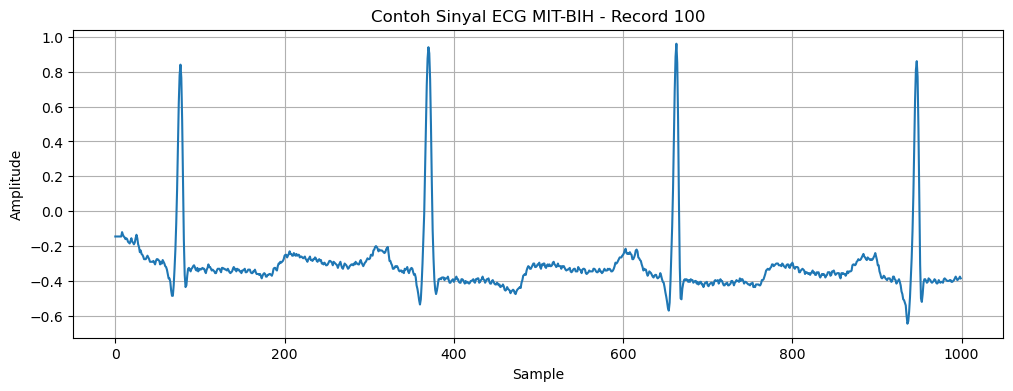

In [4]:
# Ambil sinyal lead MLII
signal = record.p_signal[:, 0]

# Plot
plt.figure(figsize=(12, 4))
plt.plot(signal[:1000])  # Plot 1000 sample pertama
plt.title("Contoh Sinyal ECG MIT-BIH - Record 100")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [5]:
def preprocess_signal(signal, fs=360):
    nyq = 0.5 * fs
    # High-pass filter
    high_b, high_a = butter(2, 0.5 / nyq, btype='high')
    filtered = filtfilt(high_b, high_a, signal)

    # Notch filter 50 Hz
    notch_freq = 50
    b_notch, a_notch = iirnotch(notch_freq, Q=30, fs=fs)
    filtered = filtfilt(b_notch, a_notch, filtered)

    # Low-pass filter
    low_b, low_a = butter(2, 40 / nyq, btype='low')
    filtered = filtfilt(low_b, low_a, filtered)

    # Normalisasi
    normalized = (filtered - np.mean(filtered)) / np.std(filtered)
    return normalized

# 4. Fungsi Segmentasi Beat
def segment_beats(signal, beat_samples, window=(-90, 160), fs=360):
    window_samples = [int(w * fs / 1000) for w in window]
    segments = []
    for sample in beat_samples:
        start = sample + window_samples[0]
        end = sample + window_samples[1]
        if start >= 0 and end < len(signal):
            segments.append(signal[start:end])
    return np.array(segments)


In [6]:
record_list = [
    '100', '101', '102', '103', '104', '105', '106', '107',
    '108', '109', '111', '112', '113', '114', '115', '116',
    '117', '118', '119', '121', '122', '123', '124', '200',
    '201', '202', '203', '205', '207', '208', '209', '210',
    '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

In [7]:
all_signals = []
all_labels = []

for record_name in record_list:
    try:
        # Baca sinyal dan anotasi
        signal, fields = wfdb.rdsamp(record_path + record_name, channels=[0])  # Lead 0
        annotations = wfdb.rdann(record_path + record_name, 'atr')

        # Validasi Anotasi
        valid_annotations = [x for x in annotations.symbol if x not in ['[', ']', 'x', '(', ')', '`', "'"]]
        valid_beat_indices = [i for i, sym in enumerate(annotations.symbol) if sym in valid_annotations]

        if not valid_beat_indices:
            print(f"Tidak ada anotasi valid di {record_name}")
            continue

        # Ambil sinyal dan anotasi valid
        valid_signal = signal.flatten()
        valid_annotations = [annotations.symbol[i] for i in valid_beat_indices]
        valid_beat_samples = np.array(annotations.sample)[valid_beat_indices]

        # Filtering dan Normalisasi
        processed_signal = preprocess_signal(valid_signal)

        # Segmentasi Beat
        beat_segments = segment_beats(processed_signal, valid_beat_samples)

        min_len = min(len(beat_segments), len(valid_annotations))
        beat_segments = beat_segments[:min_len]
        valid_annotations = valid_annotations[:min_len]
        # if len(beat_segments) == len(valid_annotations):
        #     all_signals.extend(beat_segments)
        #     all_labels.extend(valid_annotations)
        #     print(f"Berhasil proses {record_name} | Beat={len(beat_segments)}, Label={len(valid_annotations)}")
        # else:
        #     print(f"❌ Skip {record_name} | Mismatch Beat vs Label: {len(beat_segments)} vs {len(valid_annotations)}")
        #         # Simpan hasil
        all_signals.extend(beat_segments)
        all_labels.extend(valid_annotations)

        print(f"Berhasil proses rekaman: {record_name} | Beat ditemukan: {len(beat_segments)}")
    except Exception as e:
        print(f"Gagal proses rekaman {record_name}: {e}")


Berhasil proses rekaman: 100 | Beat ditemukan: 2272
Berhasil proses rekaman: 101 | Beat ditemukan: 1873
Berhasil proses rekaman: 102 | Beat ditemukan: 2192
Berhasil proses rekaman: 103 | Beat ditemukan: 2090
Berhasil proses rekaman: 104 | Beat ditemukan: 2311
Berhasil proses rekaman: 105 | Beat ditemukan: 2691
Berhasil proses rekaman: 106 | Beat ditemukan: 2098
Berhasil proses rekaman: 107 | Beat ditemukan: 2140
Berhasil proses rekaman: 108 | Beat ditemukan: 1812
Berhasil proses rekaman: 109 | Beat ditemukan: 2534
Berhasil proses rekaman: 111 | Beat ditemukan: 2132
Berhasil proses rekaman: 112 | Beat ditemukan: 2549
Berhasil proses rekaman: 113 | Beat ditemukan: 1794
Berhasil proses rekaman: 114 | Beat ditemukan: 1889
Berhasil proses rekaman: 115 | Beat ditemukan: 1961
Berhasil proses rekaman: 116 | Beat ditemukan: 2420
Berhasil proses rekaman: 117 | Beat ditemukan: 1539
Berhasil proses rekaman: 118 | Beat ditemukan: 2290
Berhasil proses rekaman: 119 | Beat ditemukan: 2094
Berhasil pro

In [8]:
# 1. Pastikan all_signals dan all_labels adalah list Python
print("Panjang all_signals:", len(all_signals))   # Harus sama dengan all_labels
print("Panjang all_labels:", len(all_labels))

Panjang all_signals: 112407
Panjang all_labels: 112407


In [9]:
class_mapping = {
    'N': 'N',     # Normal
    'L': 'N',     # Left bundle branch block
    'R': 'N',     # Right bundle branch block
    'B': 'N',     # Bundle branch block (unspecified)
    'A': 'A',     # Atrial premature
    'a': 'A',     # Aberrated atrial premature
    'J': 'A',     # Junctional premature
    'S': 'A',     # Supraventricular premature
    'V': 'V',     # Premature ventricular contraction
    'r': 'V',     # R-on-T premature ventricular contraction
    'F': 'V',     # Fusion of ventricular and normal
    'e': 'O',     # Atrial escape
    'j': 'O',     # Junctional escape
    '/': 'O',     # Paced beat
    'f': 'O',     # Fusion of paced and normal
    'E': 'O',     # Ventricular escape
    'Q': 'O',     # Unclassifiable
    '?': 'O'      # Unknown
}


In [17]:
# Setelah loop selesai
all_signals = np.array(all_signals)
all_labels = np.array(all_labels)

# Pastikan jumlah sinyal == jumlah label
assert len(all_signals) == len(all_labels), "all_signals dan all_labels tidak sepanjang!"


# Lanjutkan filtering
label_order = ['N', 'A', 'V', 'O']
filtered_mask = [lbl in class_mapping for lbl in all_labels]
all_signals_filtered = all_signals[filtered_mask]
all_labels_mapped = np.array([class_mapping[lbl] for lbl in all_labels[filtered_mask]])
all_labels_encoded = np.array([label_order.index(cls) for cls in all_labels_mapped])


In [18]:
print("all_labels_mapped shape:", all_labels_mapped.shape)

all_labels_mapped shape: (109459,)


In [43]:
print("all_signals shape:", all_signals.shape)
print("all_labels shape:", all_labels.shape)

all_signals shape: (112407, 89)
all_labels shape: (112407,)


In [44]:
np.save('all_beat_segments.npy', all_signals_filtered)
np.save('all_beat_labels_encoded.npy', all_labels_encoded)


In [20]:
# 12. Cek distribusi label
print(f"Total beat valid: {len(all_labels_encoded)}")
unique, counts = np.unique(all_labels_mapped, return_counts=True)
print("Distribusi label:")
print(dict(zip(unique, counts)))

Total beat valid: 109459
Distribusi label:
{'A': 2780, 'N': 90352, 'O': 8394, 'V': 7933}


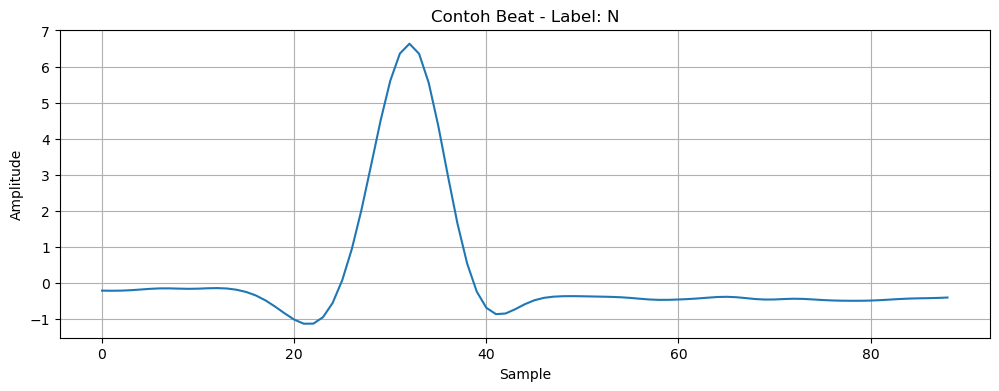

: 

In [ ]:
# 13. Visualisasi Contoh Beat
plt.figure(figsize=(12, 4))
plt.plot(all_signals_filtered[0], label='Beat')
plt.title(f"Contoh Beat - Label: {all_labels_mapped[0]}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()